# El Fin (Final Exam) for AMPTH-2017/APMA E-207

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Monday, December 17th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

#### Group 44 - Braavos

**Joe Davison<br>
Anna Davydova<br>
Michael S. Emanuel<br>
Dylan Randle<br>**

In [38]:
import numpy as np
import scipy.stats
import pandas as pd
import pymc3 as pm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns

In [15]:
# Additional imports
import pickle
from IPython.display import display
import warnings
from typing import Dict

In [16]:
# Utilities for serializing variables
def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)

## Q1: GLMs with correlation

### The dataset: A Bangladesh Contraception use census

This problem is based on one-two (12H1 and continuations ) from your textbook. The data is in the file `bangladesh.csv`. These data are from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables:

- (1) `district`: ID number of administrative district each woman resided in
- (2) `use.contraception`: An indicator (0/1) of whether the woman was using contraception
- (3) `urban`: An indicator (0/1) of whether the woman lived in a city, as opposed to living in a rural area
- (4) `woman`: a number indexing a single woman in this survey
- (5) `living.chidren`: the number of children living with a woman
- (6) `age.centered`: a continuous variable representing the age of the woman with the sample mean subtracted

We need to make sure that the cluster variable, district, is a contiguous set of integers, so that we can use the index to differentiate the districts easily while sampling ((look at the Chimpanzee models we did in lab to understand the indexing). So create a new contiguous integer index to represent the districts. Give it a new column in the dataframe, such as `district.id`.

You will be investigating the dependence of contraception use on the district in which the survey was done. Specifically, we will want to regularize estimates from those districts where very few women were surveyed. We will further want to investigate whether the areas of residence (urban or rural) within a district impacts a woman's use of contraception.

Feel free to indulge in any exploratory visualization which helps you understand the dataset better.

In [20]:
# Serialize variables for GLM quesion
fname: str = 'glm.pickle'
vartbl: Dict = load_vartbl(fname)

In [54]:
# Load the dataset
df = pd.read_csv('bangladesh.csv', sep=';')
# Generate map of distinct districts
district_id_map = {d:i for i, d in enumerate(sorted(set(df.district)))}
# Add new column district_id to the dataset; these are contiguous integers 0-59
df['district_id'] = df.district.map(district_id_map)

# Rename the columns to avoid the confusing '.' in column names
df.rename(axis='columns', inplace=True, mapper=
    {'use.contraception':'use_contraception',
     'living.children':'living_children',
     'age.centered':'age_centered',
     })

# The number of districts
num_districts: int = len(district_id_map)

# Create a dataset aggregated by district (sufficient statistic for the by district model)
agg_tbl = {
        'woman': ['count'],
        'use_contraception': ['sum']
        } 
df_district = df.groupby(by=df.district_id).agg(agg_tbl)
df_district.columns = ["_".join(x) for x in df_district.columns.ravel()]
# The number of women sampled in each district
district_count = df_district.woman_count

# Set the number of samples for this problem (used in multiple parts)
num_samples: int = 11000
num_tune: int = 1000

## Part A

We will use `use.contraception` as a Bernoulli response variable. 

When we say "fit" below, we mean, specify the model, plot its graph, sample from it, do some tests, and forest-plot and summarize the posteriors, at the very least.

**A1** Fit a traditional "fixed-effects" model which sets up district-specific intercepts, each with its own Normal(0, 10) prior. That is, the intercept is modeled something like 

```python
alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
p=pm.math.invlogit(alpha_district[df.district_id])
```

Why should there not be any overall intercept in this model? 

**A2** Fit a multi-level "varying-effects" model with an overall intercept `alpha`, and district-specific intercepts `alpha_district`. Assume that the overall intercept has a Normal(0, 10) prior, while the district specific intercepts are all drawn from the **same** normal distribution with mean 0 and standard deviation $\sigma$. Let $\sigma$ be drawn from HalfCauchy(2). The setup of this model is similar to the per-chimanzee models in the prosocial chimanzee labs.

**A3** What does a posterior-predictive sample in this model look like? What is the difference between district specific posterior predictives and woman specific posterior predictives. In other words, how might you model the posterior predictive for a new woman being from a particular district vs that os a new woman in the entire sample? This is a word answer; no programming required.

**A4** Plot the predicted proportions of women in each district using contraception against the id of the district, in both models. How do these models disagree? Look at the extreme values of predicted contraceptive use in the fixed effects model. How is the disagreement in these cases?

**A5** Plot the absolute value of the difference in probability of contraceptive use against the number of women sampled in each district. What do you see?

**A1** Fit a traditional "fixed-effects" model which sets up district-specific intercepts, each with its own Normal(0, 10) prior. That is, the intercept is modeled something like

alpha_district = pm.Normal('alpha_district', 0, 10, shape=num_districts)
p=pm.math.invlogit(alpha_district[df.district_id])

**View Data Aggregeated by District**

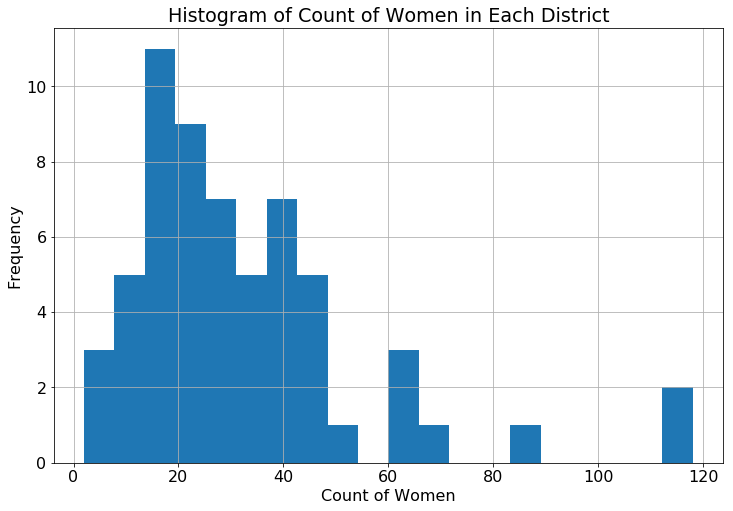

In [51]:
fig, ax = plt.subplots(figsize=[12,8])
ax.set_title('Histogram of Count of Women in Each District')
ax.set_xlabel('Count of Women')
ax.set_ylabel('Frequency')
ax.hist(df_district.woman_count, bins=20)
ax.grid()

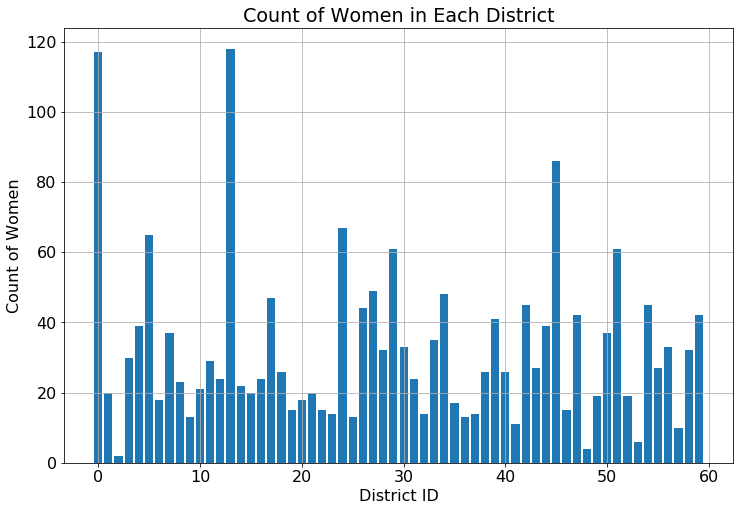

In [52]:
fig, ax = plt.subplots(figsize=[12,8])
ax.set_title('Count of Women in Each District')
ax.set_xlabel('District ID')
ax.set_ylabel('Count of Women')
ax.bar(df_district.index.values, df_district.woman_count)
ax.grid()

We can see that there are three districts with small sample sizes.  These will be hard to estimate in this model.

**Specify the Model and Draw Samples**

In [45]:
# Define the fixed-effects model
with pm.Model() as model_fe:
    # Set the prior for the intercept in each district
    alpha_district = pm.Normal('alpha_district', mu=0.0, sd=10.0, shape=num_districts)
    # Set the probability that each woman uses contraception in this model
    # It depends only on the district she lives in
    p = pm.math.invlogit(alpha_district[df.district_id])
    # The response variable - whether this woman used contraception; modeled as Bernoulli
    # Bind this to the observed values
    use_contraception = pm.Bernoulli('use_contraception', p=p, observed=df['use_contraception'])

# Sample from the fixed-effects model
try:
    trace_fe = vartbl['trace_fe']
    print(f'Loaded samples for the Fixed Effects model in trace_fe.')
except:
    with model_fe:
        trace_fe = pm.sample(draws=num_samples, tune=num_tune, chains=2, cores=1)
    vartbl['trace_fe'] = trace_fe
    save_vartbl(vartbl, fname)

C:\Python\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Loaded samples for the Fixed Effects model in trace_fe.


**Tabular Summary of the 60 alpha Parameters for Fixed Effects Model**

In [30]:
summary_fe = pm.summary(trace_fe)
display(summary_fe)

C:\Python\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_district__0,-1.074937,0.212010,0.001200,-1.476153,-0.649695,30787.638175,0.999982
alpha_district__1,-0.647616,0.487195,0.002605,-1.586008,0.318893,29522.470965,0.999975
alpha_district__2,8.499071,5.944975,0.045668,-0.595392,20.529047,13873.114201,1.000474
alpha_district__3,0.002371,0.368648,0.001789,-0.725373,0.727533,37196.093185,0.999955
alpha_district__4,-0.593987,0.339388,0.001693,-1.266390,0.066562,38051.904668,0.999955
alpha_district__5,-0.899027,0.273412,0.001531,-1.436123,-0.379232,34826.733519,0.999969
alpha_district__6,-1.015082,0.546497,0.002768,-2.108437,0.037040,33883.614080,0.999956
alpha_district__7,-0.513246,0.343578,0.001810,-1.180719,0.165880,32759.591334,0.999955
alpha_district__8,-0.867516,0.462268,0.002795,-1.777781,0.045762,29683.096142,0.999963
alpha_district__9,-2.925882,1.229452,0.009059,-5.432440,-0.815025,19657.051989,0.999995


**Plot Graphs for Fixed Effects Model: Traceplot, Autocorrplot**

C:\Python\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025060FB1940>,
      dtype=object)

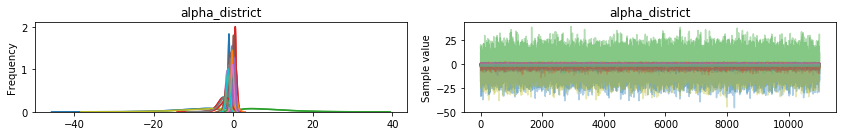

In [25]:
pm.traceplot(trace_fe)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000250613DA828>,
      dtype=object)

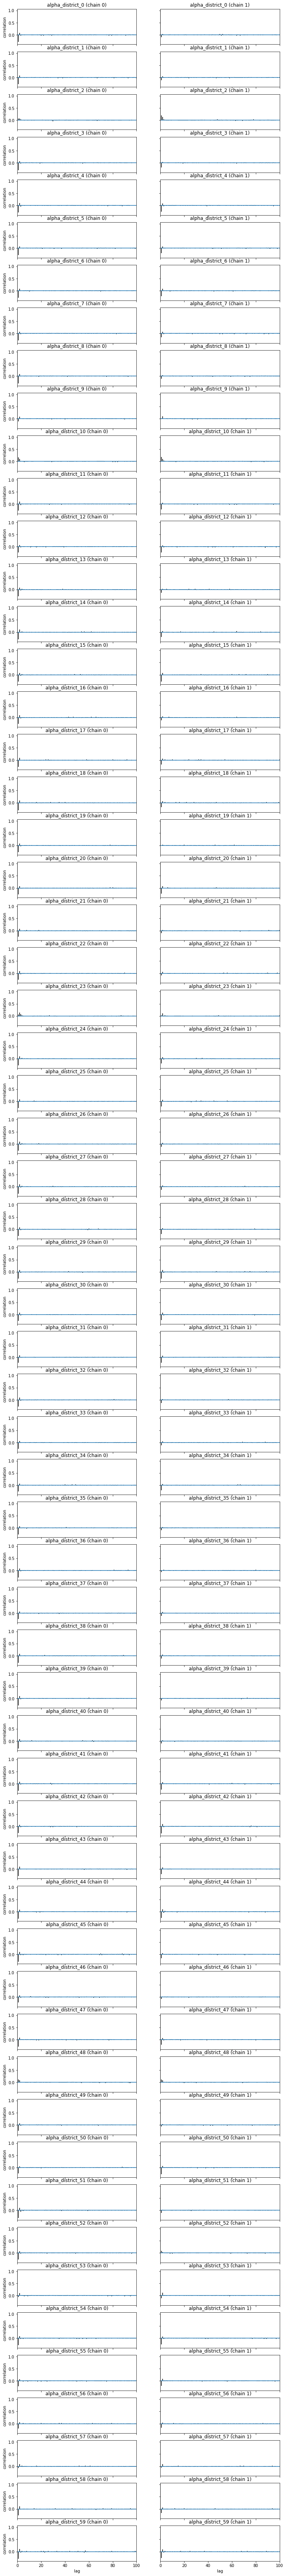

In [26]:
pm.autocorrplot(trace_fe)

With 60 variables (one for each district) it can be a bit difficult to visualize what's going on.  The autocorr plots look OK with very low correlations after the first handful of steps.  Most of the alpha parameters for each district are clustered together.  A few of them have very wide bases; these are the districts with small number of samples.

**Whisker Plot of Posterior Intercepts for Each District**

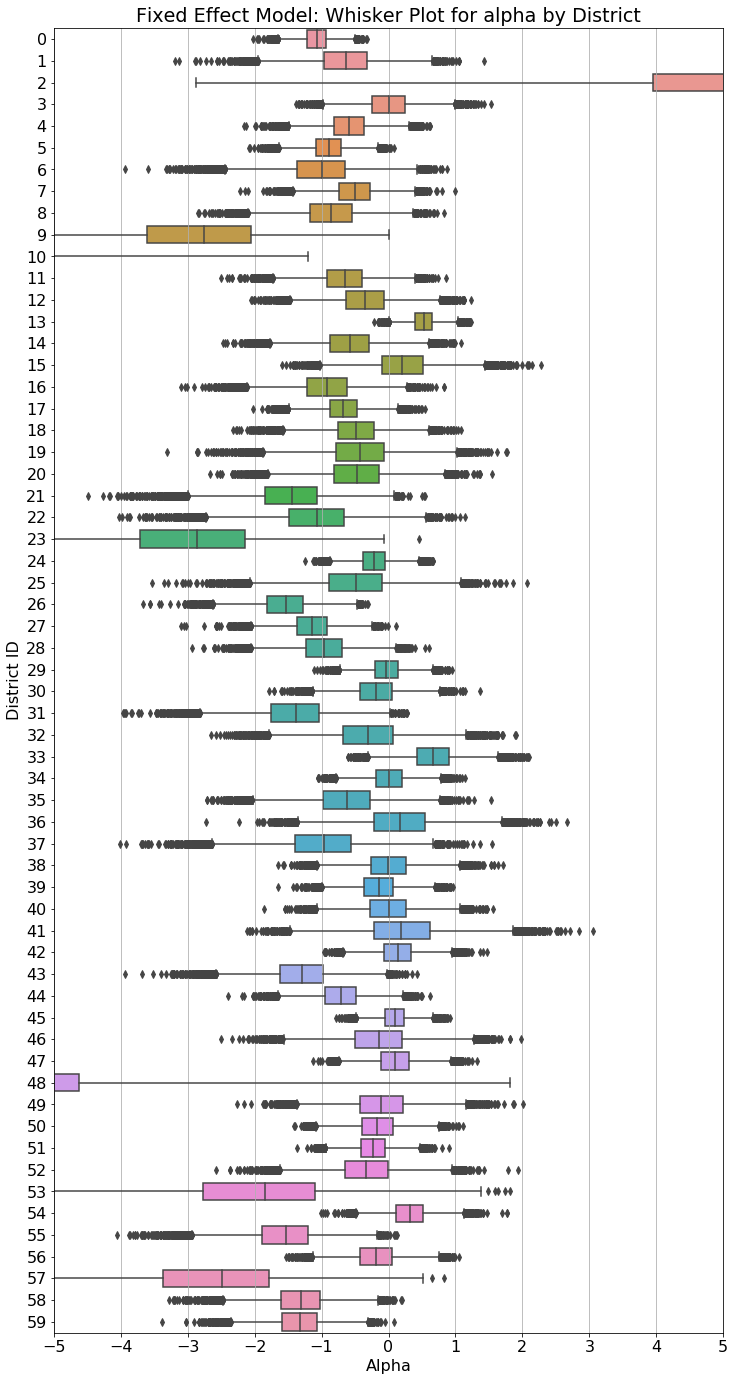

In [43]:
# Samples of alpha as a an Nx60 array
alpha_samples_fe = trace_fe.get_values('alpha_district')
# Arrange the alpha samples into a dataframe for plotting
col_names_fe = [f'alpha_{i}' for i in range(num_districts)]
df_alpha_samples_fe = pd.DataFrame(data=alpha_samples_fe, columns = col_names_fe)

# Generate a whisker plot
mpl.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=[12,24])
ax.set_title('Fixed Effect Model: Whisker Plot for alpha by District')
ax.set_xlabel('Alpha')
ax.set_ylabel('District ID')
ax.set_xlim(-5, 5)
ax.set_xticks(np.arange(-5,6))
ax.grid()
sns.boxplot(data=alpha_samples_fe, orient='h', ax=ax)

Unlike the earlier plots, this one is very readable.  It shows the alpha parameter (intercept) for each district.  A high alpha means women in that district are more likely to use contraception.

**Forest Plot for Fixed Effect Model**

(0.8, 1.2)

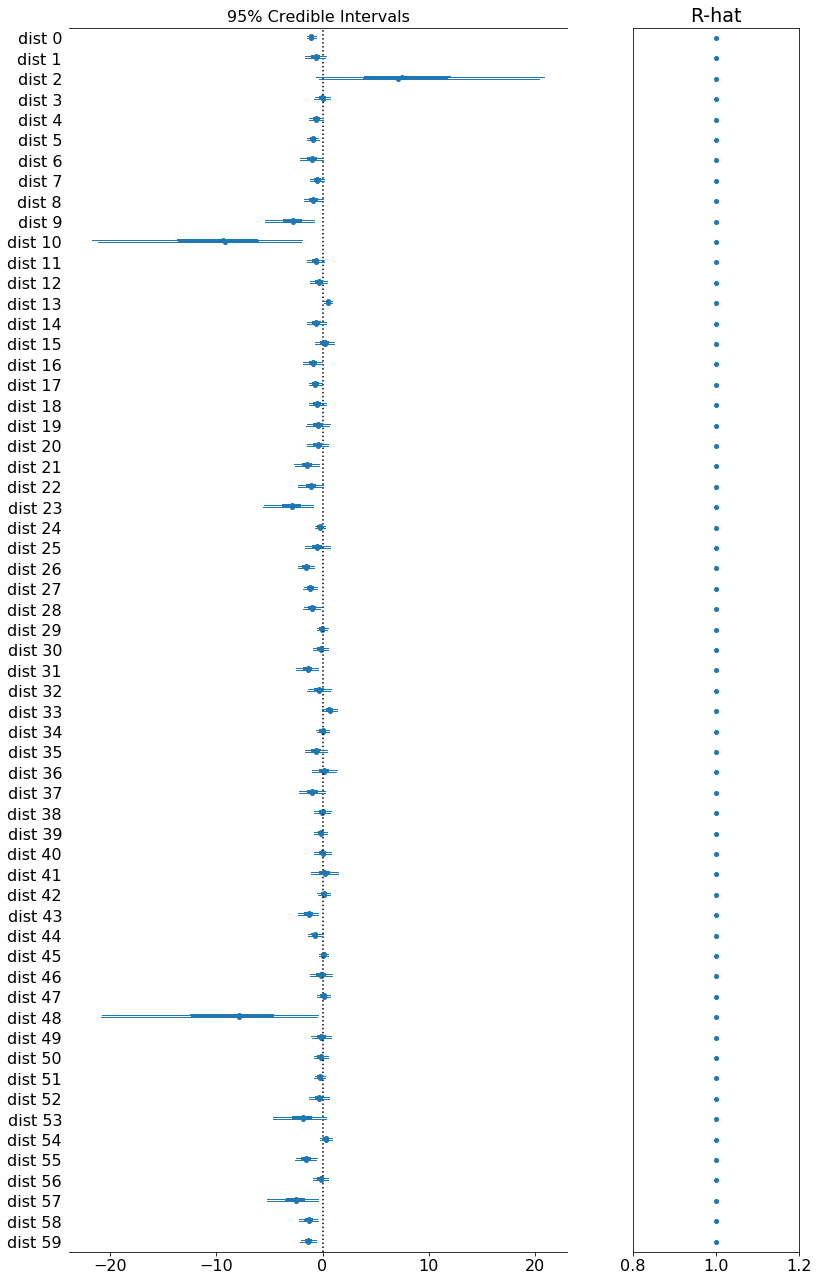

In [61]:
fig = plt.figure(figsize=(12,20))
gs = pm.forestplot(trace_fe, ylabels=[f'dist {i}' for i in range(num_districts)],)
gs.figure = fig
ax1, ax2 = fig.axes
ax1.set_xlim(0.8, 1.2)

**Tests for Fixed Effect Model**

In [33]:
# Check n_eff, the number of effective draws
n_eff = summary_fe['n_eff']
n_eff_mean = np.mean(n_eff)
n_eff_min = np.min(n_eff)
print(f'Mean of n_eff for {num_districts} alpha parameters is {n_eff_mean:0.0f}')
print(f'Min of n_eff is {n_eff_min:0.0f}')

# Check Rhat, the correlation between of parameter estimates between chains
rhat = summary_fe['Rhat']
rhat_mean = np.mean(rhat)
rhat_min = np.min(rhat)
print(f'Mean of RHat for {num_districts} alpha parameters is {rhat_mean:0.3f}')
print(f'Min of Rhat is {rhat_min:0.3f}')

Mean of n_eff for 60 alpha parameters is 30730
Min of n_eff is 13399
Mean of RHat for 60 alpha parameters is 1.000
Min of Rhat is 1.000


The number of effective draws is high and the correlations between chains are good.  These results seem fine, and don't indicate any sampling problems.  Also there were no warnings from the samplers.

**Plot Posterior: alpha for Each District**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002506AD99BA8>,
      dtype=object)

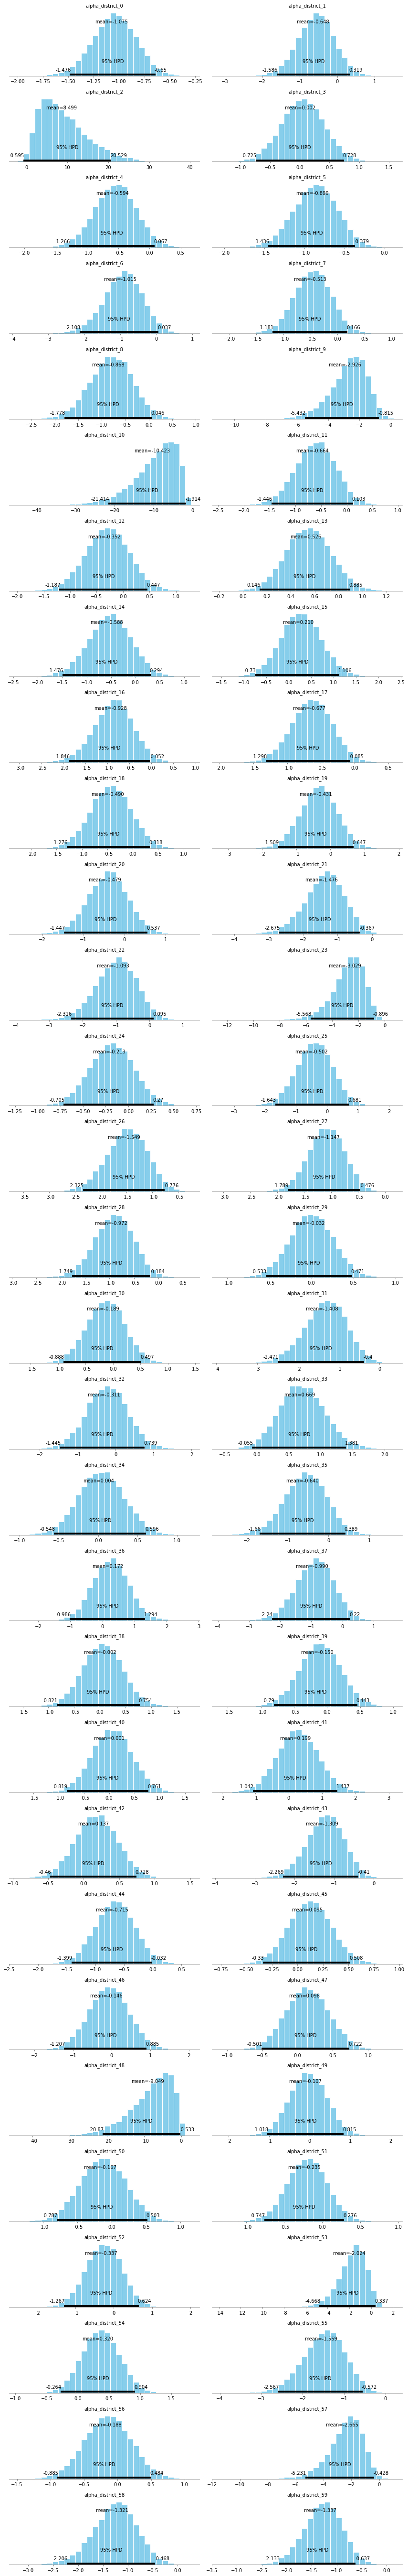

In [28]:
pm.plot_posterior(trace_fe)

**Summarize the Posteriors**

In [53]:
display(summary_fe)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_district__0,-1.074937,0.212010,0.001200,-1.476153,-0.649695,30787.638175,0.999982
alpha_district__1,-0.647616,0.487195,0.002605,-1.586008,0.318893,29522.470965,0.999975
alpha_district__2,8.499071,5.944975,0.045668,-0.595392,20.529047,13873.114201,1.000474
alpha_district__3,0.002371,0.368648,0.001789,-0.725373,0.727533,37196.093185,0.999955
alpha_district__4,-0.593987,0.339388,0.001693,-1.266390,0.066562,38051.904668,0.999955
alpha_district__5,-0.899027,0.273412,0.001531,-1.436123,-0.379232,34826.733519,0.999969
alpha_district__6,-1.015082,0.546497,0.002768,-2.108437,0.037040,33883.614080,0.999956
alpha_district__7,-0.513246,0.343578,0.001810,-1.180719,0.165880,32759.591334,0.999955
alpha_district__8,-0.867516,0.462268,0.002795,-1.777781,0.045762,29683.096142,0.999963
alpha_district__9,-2.925882,1.229452,0.009059,-5.432440,-0.815025,19657.051989,0.999995


We can start summarizing the posteriors with the table above.  It's a lot to take in because there are 60 districts.  Let's do some higher level summaries below.

In [58]:
# Compute the weighted average of the mean and sd of alpha 
# weighting is by the number of women in each district
alpha_mean_wtd = np.average(a=summary_fe['mean'], weights=district_count)
alpha_sd_wtd = np.average(a=summary_fe['sd'], weights=district_count)

print(f'Weighted average of mean and sd alpha, weighted by number of women in each district:')
print(f'alpha_mean_wtd: {alpha_mean_wtd:0.4f}')
print(f'alpha_sd_wtd:    {alpha_sd_wtd:0.4f}')

Weighted average of mean and sd alpha, weighted by number of women in each district:
alpha_mean_wtd: -0.6053
alpha_sd_wtd:    0.4456


This is telling us that overall, women in this survey are more likely not to use contraception (mean alpha weighted by size is negative).  The size of the negative alpha is somewhat larger than the weighted average standard deviation, so the effect has a reasonable size.  This lines up with the overall mean rate of contraception use in the surve, 39.25%.

**Why should there not be any overall intercept in this model?**

This model fits a parameter $\alpha$ to each district the determines the probability $p$ that women in the district use contraception according to a logistic distribution.  Adding an overall intercept would just create a new parameter that was colinear with the 60 alphas, one for each district.  It would be redundant.  It could create sampling problems due to misindetification, since a model where the overall intercept was 0.1 higher and all the $alpha_i$ were 0.1 lower would be the same.  It's worth pointing out here that if the priors on the individual districts were grouped more tightly around zero, while the prior for the overall rate was wider, then this model specification might have some benefits.

**A2** Fit a multi-level "varying-effects" model with an overall intercept `alpha`, and district-specific intercepts `alpha_district`. Assume that the overall intercept has a Normal(0, 10) prior, while the district specific intercepts are all drawn from the **same** normal distribution with mean 0 and standard deviation $\sigma$. Let $\sigma$ be drawn from HalfCauchy(2). The setup of this model is similar to the per-chimanzee models in the prosocial chimanzee labs.

**A3** What does a posterior-predictive sample in this model look like? What is the difference between district specific posterior predictives and woman specific posterior predictives. In other words, how might you model the posterior predictive for a new woman being from a particular district vs that os a new woman in the entire sample? This is a word answer; no programming required.

**A4** Plot the predicted proportions of women in each district using contraception against the id of the district, in both models. How do these models disagree? Look at the extreme values of predicted contraceptive use in the fixed effects model. How is the disagreement in these cases?

**A5** Plot the absolute value of the difference in probability of contraceptive use against the number of women sampled in each district. What do you see?

## Part B.

Let us now fit a model with both varying intercepts by `district_id` (like we did in the varying effects model above) and varying slopes of `urban` by `district_id`. To do this, we will 

- (a) have an overall intercept, call it `alpha`
- (b) have an overall slope of `urban`, call it `beta`.
- (c) have district specific intercepts `alpha_district`
- (d) district specific slopes for `urban`, `beta_district`
- (e) model the co-relation between these slopes and intercepts. 

We have not modelled covariance and correlation before, so look at http://am207.info/wiki/corr.html for notes on how this is done.

To see the ideas behind this, see section 13.2.2 on the income data  from your textbook (included as a pdf in this zip). Feel free to use [code with attribution from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb)..with attribution and understanding...there is some sweet pymc3 technical wrangling in there.

**B1** Write down the model as a pymc3 specification and look at its graph. Note that this model builds a 60 by 2 matrix with `alpha_district` values in the first column and `beta_district` values in the second. By assumption, the first column and the second column have correlation structure given by an LKJ prior, but there is no explicit correlation among the rows. In other words, the correlation matrix is 2x2 (not 60x60). Make sure to obtain the value of the off-diagonal correlation as a `pm.Deterministic`. (See Osvaldo Martin's code above)

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes me 7 minutes 30 seconds on my 2013 Macbook Air). Comment on the quality of the samples obtained.

**B3** Propose a method based on the reparametrization trick for multi-variate gaussians) of improving the quality of the samples obtained and implement it. (A hint can be obtained from here: https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal . Using that hint lowered the sampling time to 2.5 minutes on my laptop).

**B4** Inspect the trace of the correlation between the intercepts and slopes, plotting the correlation marginal. What does this correlation tell you about the pattern of contraceptive use in the sample? It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Also plot the predicted proportion of women using contraception, with urban women on one axis and rural on the other.  Finally, also plot the difference between urban and rural probabilities against rural probabilities. All of these will help you interpret your findings. (Hint: think in terms of low or high rural contraceptive use)

**B5** Add additional "slope" terms (one-by-one) into the model for 

- (a) the centered-age of the women and 
- (b) an indicator for whether the women have a small number or large number of existing kids in the house (you can treat 1-2 kids as low, 3-4 as high, but you might want to experiment with this split). 

Are any of these effects significant? Are any significant effects similar over the urban/rural divide?

**B6** Use WAIC to compare your models. What are your conclusions?

## Q2: Mixture of experts and mixture density networks to solve inverse problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail. We saw this model earlier in HW where we did an EM like algorithm to obtain a mixture of regressions.

The data is in `one-to-many.csv`

When we plot the data it looks like this. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

![](images/inverse.png)

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## Part A: Variational Mixture of experts

We'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here the three regression lines work in different regions of $f$. We want a pricipled way to sample from this model and to be able to produce posteriors and posterior-predictives.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. These mixing probabilities, the $\lambda$s will be modeled as a softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**A1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

**A2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

**A3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the mean"s with standard deviations showing their uncertainty overlaid on the data.

**A4** Plot the posterior predictive (mean and variance) as a function of x) for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

**A5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. You may want to contrast a prediction from a point estimate at the mean values of the $\mu$ and $\sigma$ traces at a given x (given the picked gaussian) to the "full" posterior predictive obtained from sampling from the entire trace of $\mu$ and $\sigma$ and $\lambda$. The former diagram may look something like this:

![](images/mixpred.png)

## Part B. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between A4 and A5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**B1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

**B2**: Train the network using the Adam or similiar optimizer and gradient descent/SGD. Make sure your loss converges and plot this convergence.

**B3**: Plot the MLE parameters against x. Make a plot similar to A3 above where you overlay the "means" of the gaussians against the data.  Plot traces of the mu/sigma/lambda as an aid in debugging.

**B4**: Sample from the sampling distributions at the estimated point values of $\mu$ and $\sigma$ (given cluster) to make a plot similar to A5 above

**To think but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

## Part C Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part B  directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**C1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

**C2**: Sample from the posterior predictive and produce a diagram like B4 and A5 for this model. Plot traces of the mu/sigma/lambda as an aid in debugging your sampler.

**C3**: Plot the "mean" regression curves (similar to B3 and A3). Do the "mean" regression curves in this model look the same from those in Part B?  If they differ why so?

## Q3:  Exploring Temperature in Sampling and Optimiztion

At various times in class we've discussed in very vague terms the relation between "temperature" and sampling from or finding optima of distributions.  Promises would invariably be made that at some later point we'd discuss the concept of temperature and sampling/optima finding in more detail.  Let's take this problem as an opportunity to keep our promise.

Let's start by considering the function $f(x, y)$ defined in the following code cell. $f(x, y)$ is a mixture of three well separated Gaussian probability densities.

In [6]:
make_cov = lambda  theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

theta_vec = (5.847707364986893, 5.696776968254305, 1.908095937315489)
theta1, theta2, theta3 = theta_vec

# define gaussian mixture 1 
cov1 = make_cov(theta1)
sigma1 = np.array([[2, 0],[0, 1]])
mvn1 = scipy.stats.multivariate_normal([12, 7], cov=cov1@sigma1@cov1.T)

# define gaussian mixture 2
cov2 = make_cov(theta2)
sigma2 = np.array([[1, 0],[0, 3]])
mvn2 = scipy.stats.multivariate_normal([-1, 6], cov=cov2@sigma2@cov2.T)

cov3 = make_cov(theta3)
sigma3 = np.array([[.4, 0],[0, 1.3]])
mvn3 = scipy.stats.multivariate_normal([3,-2], cov=cov3@sigma3@cov3.T)

f = lambda xvec: mvn1.pdf(xvec) + mvn2.pdf(xvec) + .5*mvn3.pdf(xvec)

p = lambda x, y: f([x,y])

## Part A Visualization and Metropolis

**A1**. Visualize $p(x, y)$ with a contour or surface plot.  Make sure to title your plot and label all axes.  What do you notice about $p(x, y)$?  Do you think it will be an easy function to sample?

**A2**. Generate 20000 samples from $p(x, y)$ using the Metropolis algorithm.  Pick individual gaussian proposals in $x$ and $y$ with $\sigma=1$, initial values, burnin parameters, and thinning parameter.  Plot traceplots of the $x$ and $y$ marginals as well as autocorrelation plots.  Plot a pathplot of your samples.  Based on your visualizations, has your Metropolis sampler generated an appropriate representation of the distribution $p(x, y)$?

A pathplot is just your samples trace overlaid on your pdf, so that you can see how the sampler traversed. It looks something like this:

![](images/pathplot.png)

## Part B: Changing pdfs using temperature

Given a function $p(x)$ we can rewrite that function in following way:

$$p(x) = e^{-(-\log(p(x))}$$

So if define the energy density for a function as $E(x)\equiv-\log{p(x)}$

We can now aim to sample from the function parameratized by a Temperature $T$.

$$p(x\vert T) = e^{-\frac{1}{T} E(x)} = p(x)^{\frac{1}{T}}$$

If we set T=1 we're sampling from our original function $p(x)$. 

**B1** In line with A1, visualize modified pdfs (dont worry about normalization) by setting the temperatures to $T=10$ and $T=0.1$. 

**B2**. Modify your Metropolis algorithm above to take a temperature parameter `T` as well as to keep track of the number of rejected proposals.  Generate 20000 samples from $p(x, y)$ at for each of the following temperatures: {0.1, 1, 3, 7, 10}. Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples at each temperature.  What happens to the number of rejections as temperature increases? In the limits $T \rightarrow 0$ and $T \rightarrow \infty$ what do you think your samplers will do?

**B3**. Approximate the $f(X)$ by the appropriate mixture of Gaussians as a way of generating samples from $f(X)$ to compare with other sampling methods.  Use scipy.stats.multivariate_normal to generate 20000 samples.  How do the histograms compare with the histograms for the samples from $f(X)$ at each temperature.  At what temperature do the samples best represent the function? 

## Part C: Parallel Tempering

Now that we've seen some of the pproperties of sampling at higher temperatures, let's explore a way to incorporate the improved exploration of the *entire pdf* from sampling at higher temperatures while still getting samples that match our distribution.  We'll use a technique called *parallel tempering*.  

The general idea of parallel tempering is to simulate $N$ replicas of the original system of interest (in our case, a single Metropolis Hastings chain), each replica at a different temperature. The temperature of a Metropolis Hastings Markov Chain defines how likely it is to sample from a low-density part of the target distribution. The high temperature systems are generally able to sample large volumes of parameter space, whereas low temperature systems, while having precise sampling in a local region of parameter space, may become trapped around local energy minima/probability maxima. Parallel tempering achieves good sampling by allowing the chains at different temperatures to exchange complete configurations. Thus, the inclusion of higher temperature chains ensures that the lower temperature chains can access *all* the low-temperature regions of phase space: the higher temperatures help these chains make the jump-over.

Darren Wilkinson's blog post has a [good description](https://darrenjw.wordpress.com/2013/09/29/parallel-tempering-and-metropolis-coupled-mcmc/) of whats going on.

Here is the idea that you must implement.

There are $N$ replicas each at different temperatures $T_i$ that produce $n$ samples each before possibly swapping states.

We simplify matters by only swapping states at adjacent temperatures.  The probability of swapping any two instances of the replicas is given by

$$A = min\left(1, \frac{p_k(x_{k+1})p_{k+1}(x_k)}{p_k(x_k) p_{k+1}(x_{k+1})}\right)$$

One of the $T_i$'s in our set will always be 1 and this is the only replica that we use as output of the Parallel tempering algorithm.

An algorithm for Parallel Tempering is as follows:

1. Initialize the parameters $\{(x_{init}, y_{init})_i\}, \{T_i\}, L$ where 
    * $L$ is the number of iterations between temperature swap proposals.
    * $\{T_i\}$ is a list of temperatures.  You'll run one chain at each temperature.
    * $\{(x_{init}, y_{init})_i\}$ is a list of starting points, one for each chain 
2. For each chain (one per temperature) use the simple Metropolis code you wrote earlier. Perform $L$ transitions on each chain.
3. Set the $\{(x_{init}, y_{init})_i\}$ for the next Metropolis run on each chain to the last sample for each chain i.
4. Randomly choose 2 chains at adjacent temperatures.
    1. Use the above formula to calculate the Acceptance probability $A$.
    2. With probability $A$, swap the positions between the 2 chains (that is swap the $x$s of the two chains, and separately swap the $y$s of the chains .
5. Go back to 2 above, and start the next L-step epoch 
6. Continue until you finish $Num. Samples//L$ epochs.


**C1**. Explain why swapping states with the given acceptance probability is in keeping with detailed balance. The linked blog post might help.

**C2**. Create a parallel tempering sampler that uses 5 chains at  the temperatures {0.1, 1, 3, 7, 10} to sample from $f(x, y)$.  Choose a value of L around 10-20.  Generate 10000 samples from $f(x, y)$.  Construct  histograms of the marginals, traceplots, autocorrelation plots, and a pathplot for your samples.

**C3**. How do your samples in **C2** compare to those of the Metropolis sampler?  How do they compare to the samples generated from the Gaussian Mixture approximation of $f(x, y)$?

## Part D. Global Optima using Simulated Annealing

We have new-found intuition about how to use temperature to improve our sampling. Lets now tackle the inverse idea: what happens if you sample at a lower temperature than 1. Our visualizations from Part B should indicate to us that the distributions become extremely tightly peaked arounnd their maxima.

If we initialized a metropolis-hastings sampler around an optimum at a really low temperature, it would find us a local minimum. But if we had a higher temperature at the beginning, we can use Metropolis-Hastings sampling at high temperatures to travel around the distribution and find all the peaks (valleys).  Then we will slowly cool down the temperature (which will allow us to escape local optima at higher temperatures) and finally focus us into a particular optimum region and allow you to find the optimum. It can be shown that for ceratin *temperture schedules* this method is guaranteed to find us a global minimum in the limit of infinite iterations.

We'll use this methd to find the global minimum of our distribution. The algorithm is as follows. Now we have only one chain, but we very slowly dial down its temperature to below T=1.

1. Initialize $(x, y)_i,T, L(T)$ where $L$ is the number of iterations at a particular temperature. 
2. Perform $L$ transitions thus(we will call this an epoch):
    1. Generate a new proposed position $(x, y)_{\ast}$ using 2 independent gaussians with $\sigma=1$.
    2. If $(x, y)_{\ast}$ is accepted (according to probability $P = e^{(-\Delta E/T)}$, set $(x, y)_{i+1} = (x, y)_{\ast}$, else set $(x, y)_{i+1} = x_{i}$  
3. Update T and L 
4. Until some fixed number of epochs, or until some stop criterion is fulfilled, goto 2.

$\Delta E$ is the change in enery, or the change in the negative log of the probability function. That is, $E = -log p(x,y)$. For a given T and L, this is just Metropolis!

This algorithm is called *simulated annealing* and we'll use it to find the global maximum for $f(X)$

**D1**. Use simulated annealing with a cooling schedule of $T_{k+1}=0.98T_{k}$ and a L(T) defined initially at 100 with $L_{k+1} = 1.2 L_k$ to find the global optima for $p(x, y)$.  Plot $E(x, y)$ vs iterations.  Given how we constructed $p(x, y)$ it should be fairly straight-forward to observe the  true optima by inspection.  How does the optima found by SA compare to the true optima?